# Ideal Parameter Analysis ($\delta=2.75$, $\tau=1.25$, $\alpha=2$) ($\delta$ very high)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.75
expected_tau = 1.25
expected_alpha = 2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

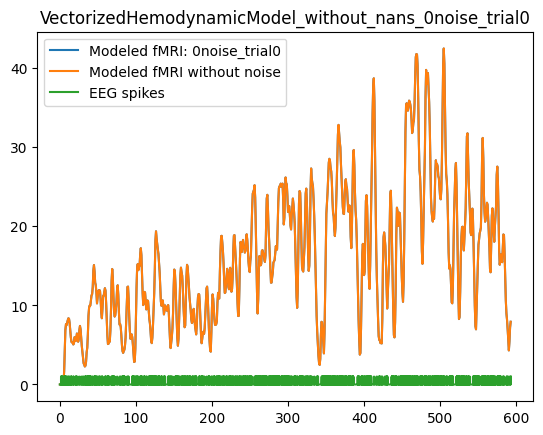

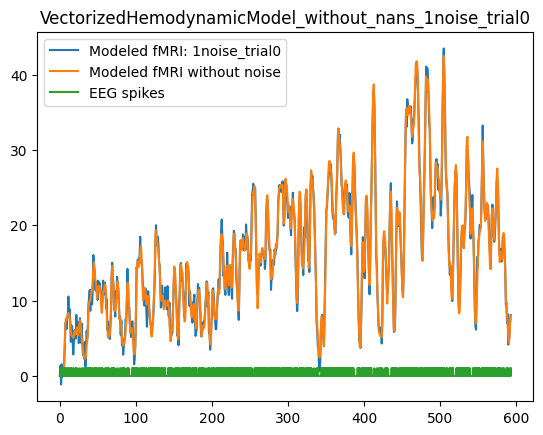

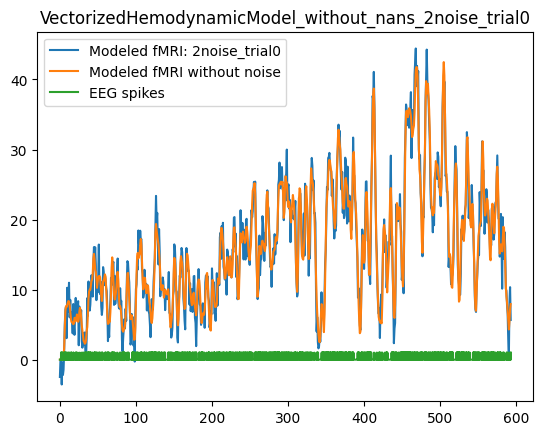

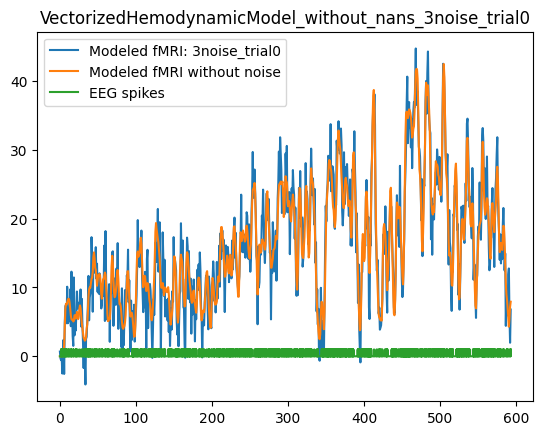

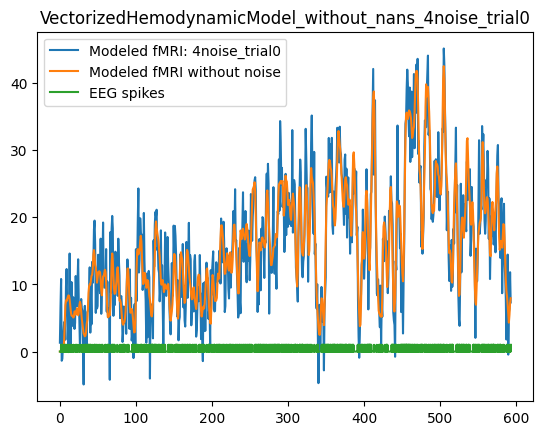

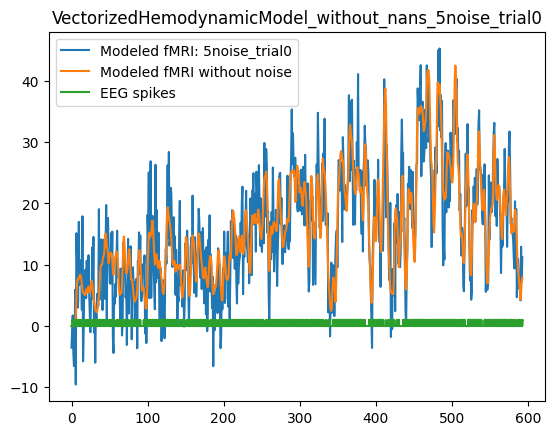

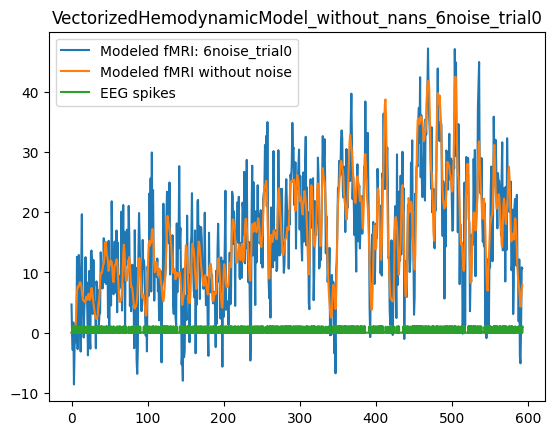

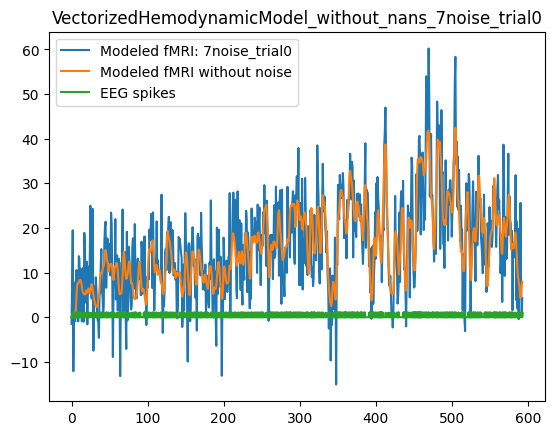

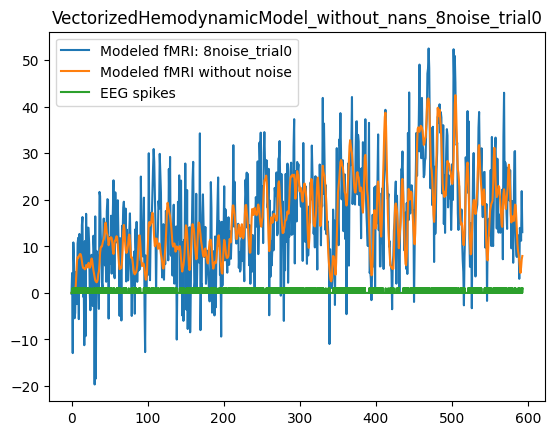

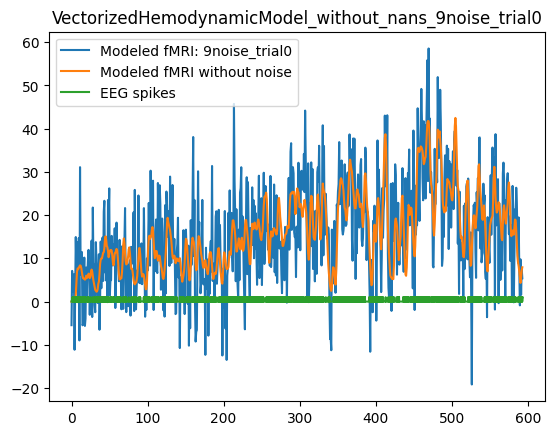

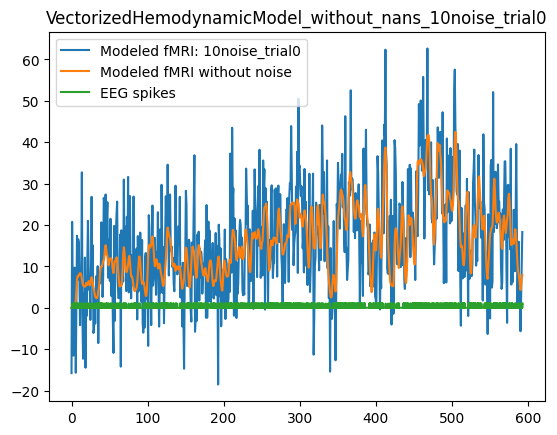

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.75, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.75, tau=1.25, alpha=2


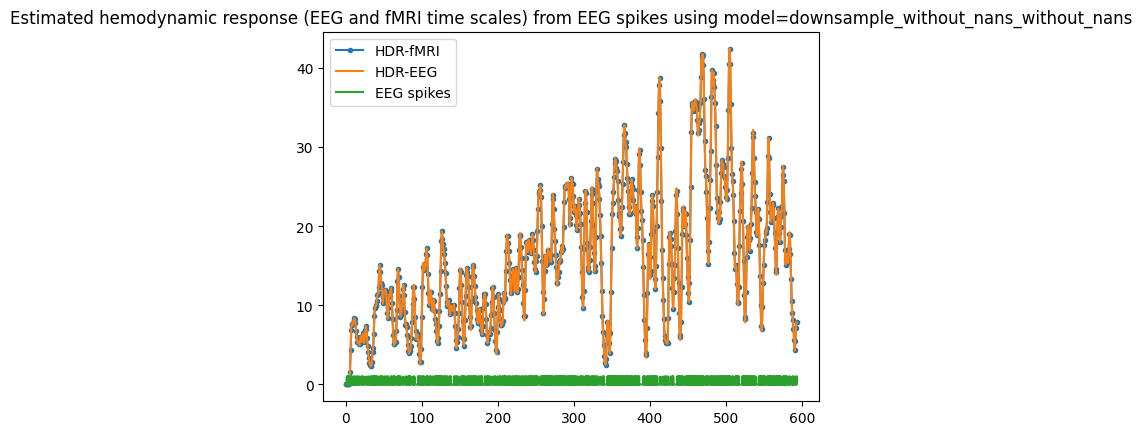

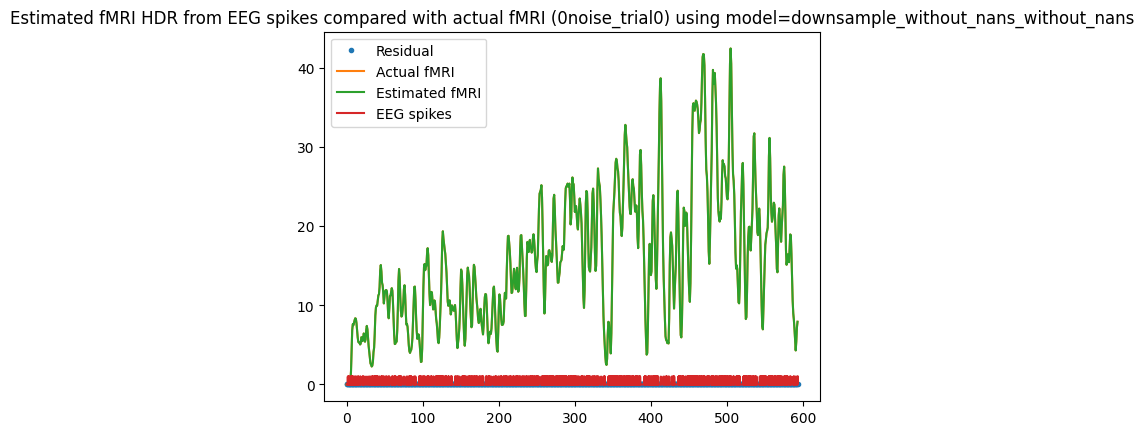

Residual Variance is 0.000000


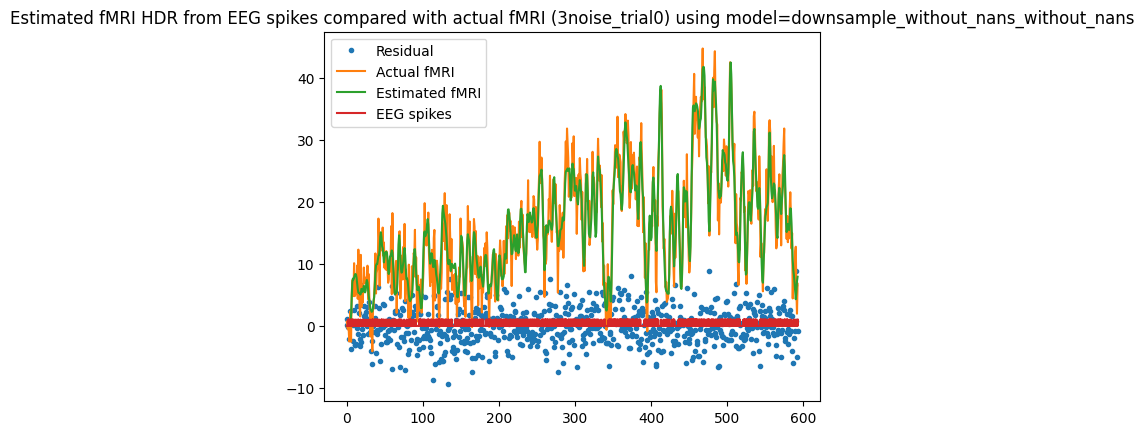

Residual Variance is 8.698529


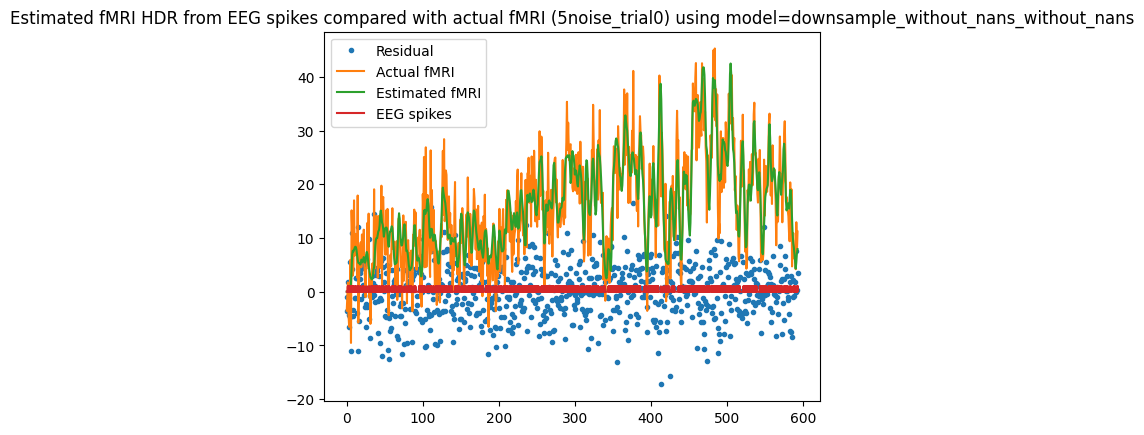

Residual Variance is 25.308868


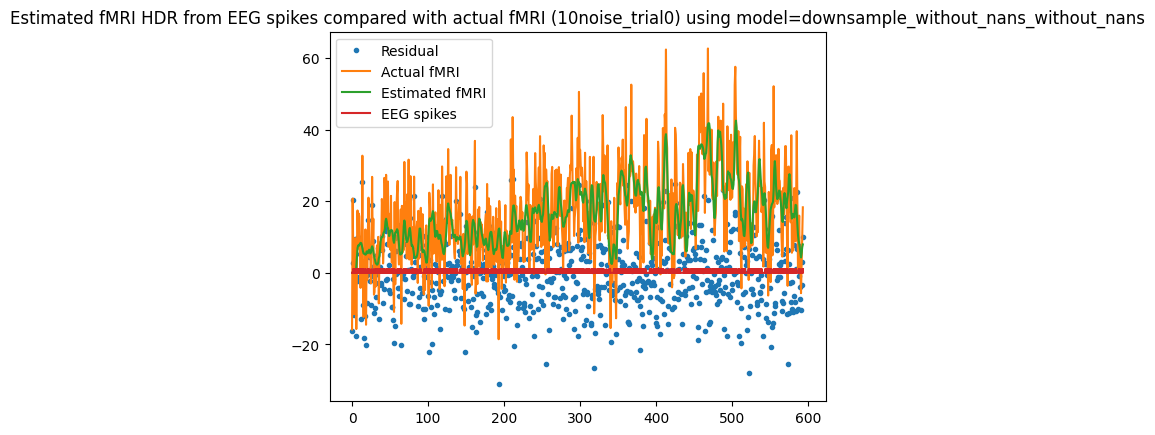

Residual Variance is 92.037799


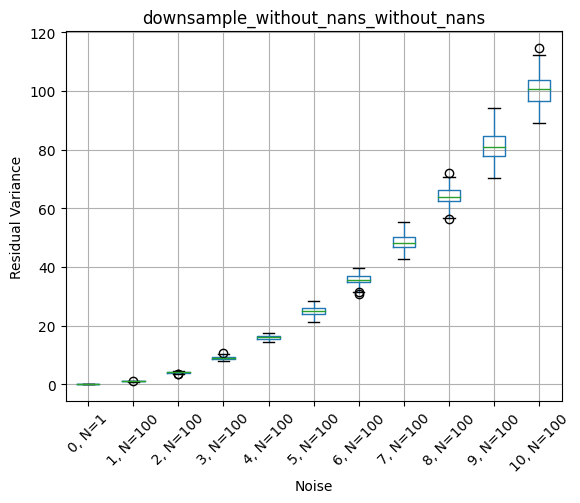

Scoring downsample_without_nans_with_nans delta=2.75, tau=1.25, alpha=2


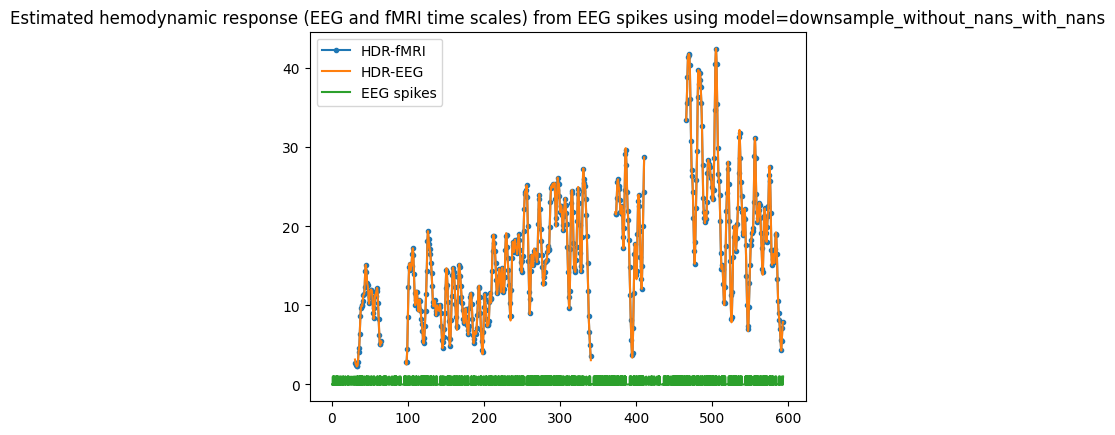

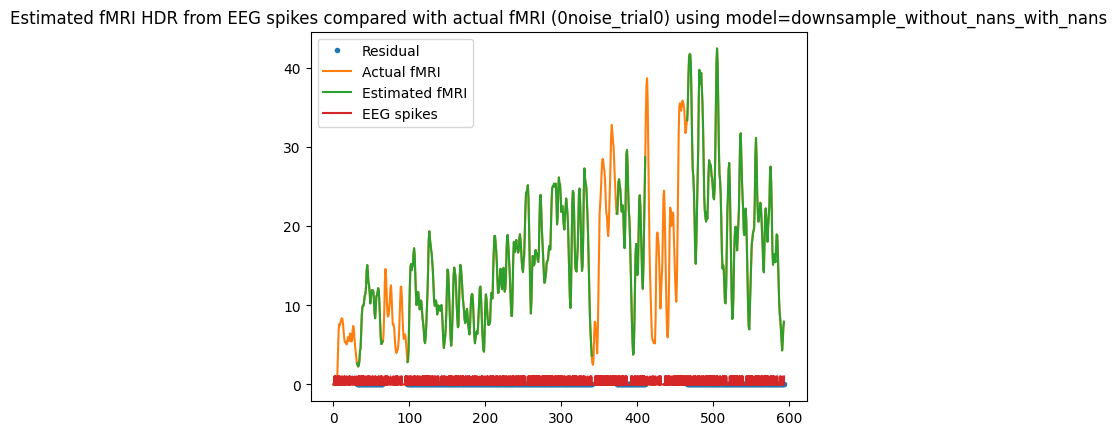

Residual Variance is 0.000000


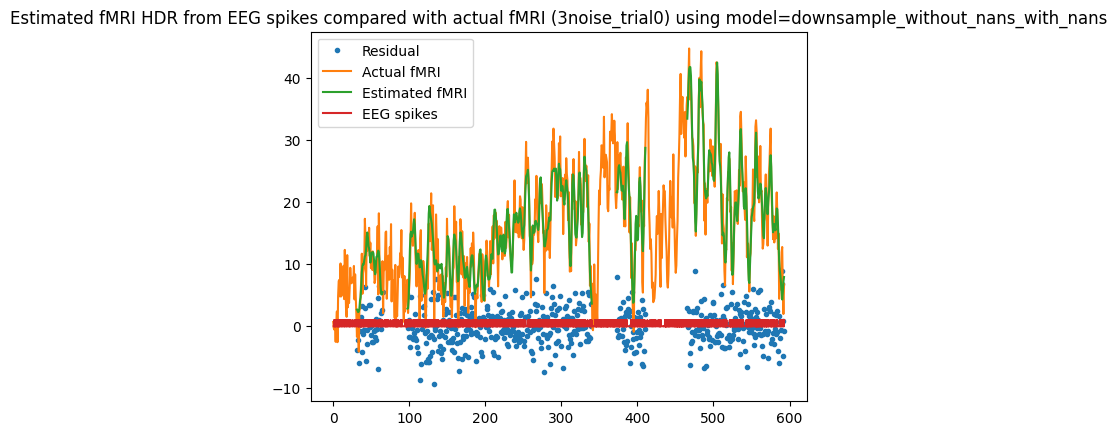

Residual Variance is 8.902811


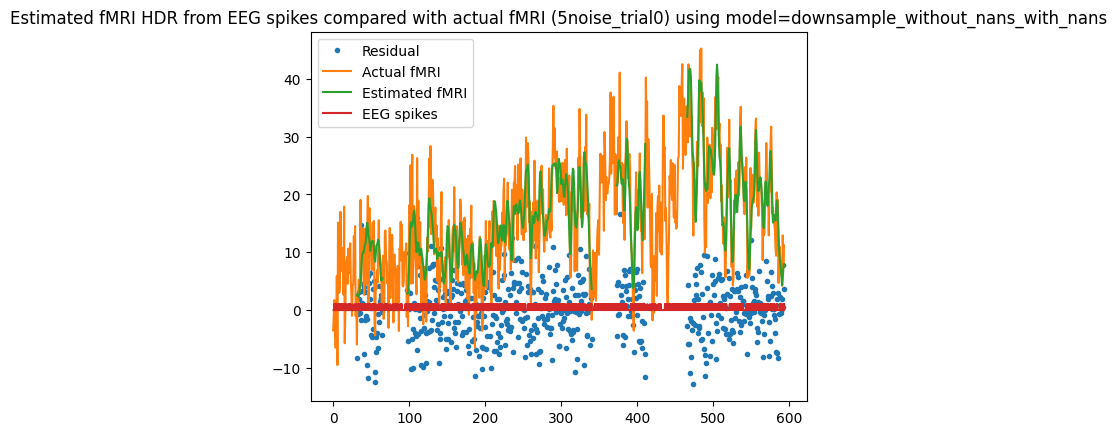

Residual Variance is 24.729338


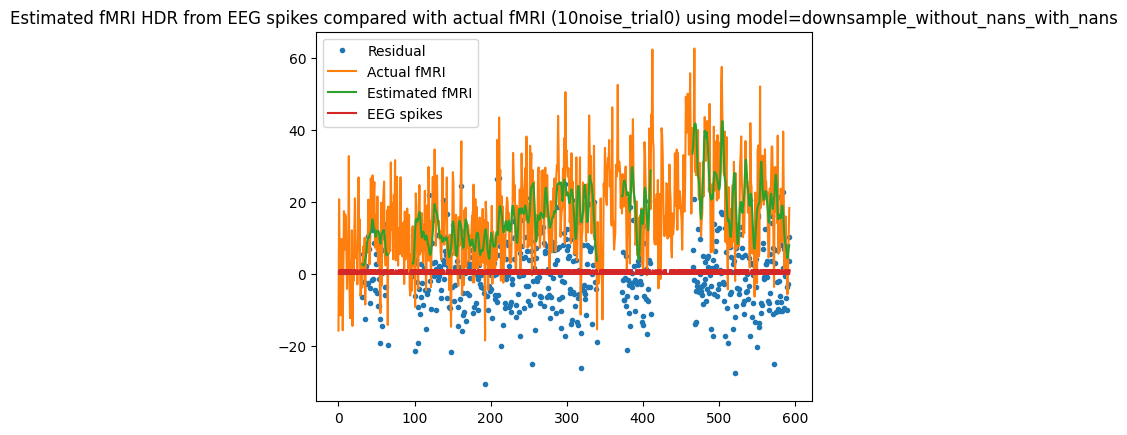

Residual Variance is 90.430389


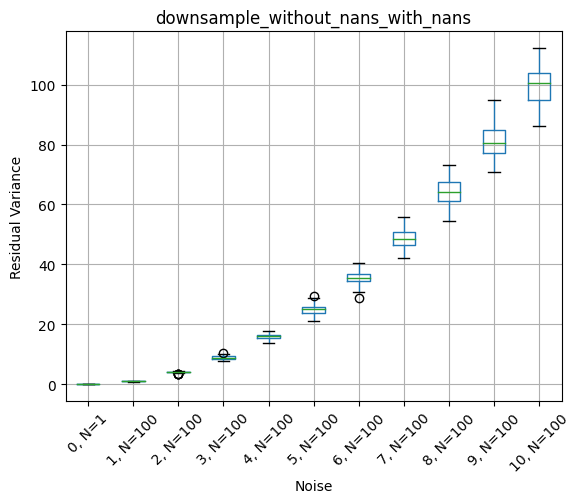

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans   50.26146800012666   
1         downsample_without_nans_with_nans  45.295143946348084   
2      downsample_without_nans_without_nans   49.59285339631367   
3         downsample_without_nans_with_nans  44.751446643724805   
4      downsample_without_nans_without_nans  48.911798280153725   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans   8.721347069488285   
18938  downsample_without_nans_without_nans  10.345487481579685   
18939     downsample_without_nans_with_nans   9.383576562512653   
18940  downsample_without_nans_without_nans  11.094476456166243   
18941     downsample_without_nans_with_nans  10.050329683421017   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0       50.08344585815811  53.810349106930516   61.16290670476942   
1       45.32577375080515    48.9479276756438   57.42588599545324   
2       49.43084397504218  53.105826180775686   60.47741865811286   
3        44.7961328409592   48.37361914272716   56.86291964350155   
4       48.76616611702911   52.38953922139294   59.77888128789646   
...                   ...                 ...                 ...   
18937   9.471657423853019  13.061731576560652  17.356426628241536   
18938    10.9377379787913  14.833187084931374  18.513425547784976   
18939  10.120927507763795   13.73994965532815   18.03548356992059   
18940  11.668099066377112  15.604499494246653  19.261071229036006   
18941  10.774986590041419  14.422485613168076    18.7205515112963   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0       65.72877205850406   71.38699743541419  ...   51.43700712116449   
1       60.06845946852558   67.81906548138502  ...  46.472236631374294   
2       65.07346519684577   70.74223804068707  ...   50.76899663839069   
3       59.54060148340312     67.276448315787  ...   45.92662335076313   
4       64.40593875790063   70.08754423064147  ...   50.08843616851336   
...                   ...                 ...  ...                 ...   
18937  24.938850396202344   33.28581956644491  ...   9.818631842233481   
18938  27.043865417751775   34.86319215215786  ...  11.286890487655693   
18939  25.613125043955208  33.936544937787794  ...  10.487451837848948   
18940  27.825826937302796  35.562456089524865  ...  12.036481341955742   
18941  26.292160793724108  34.591758275067626  ...   11.16084687923651   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0       54.43515369193809  58.638111932410666   67.11982525481109   
1       50.42028786834013   53.28035424312212  61.526146943096485   
2       53.74916200249805   57.96232876330731   66.42186491102659   
3       49.84159589451675   52.72373255380225   60.96618075195538   
4       53.05108661255168    57.2728457844145   65.71204531635712   
...                   ...                 ...                 ...   
18937  13.690701219860806   18.00234653631651  24.777651177402667   
18938  15.171625048970064  19.055764714102867   26.46118888035699   
18939  14.381301167514003    18.6667525743953  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 3.4844432999359187e-28; at
       delta   tau  alpha
16400   2.75  1.25    2.0


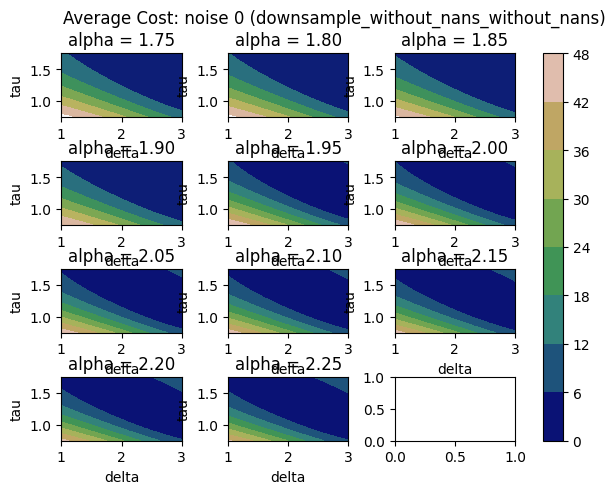

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              50.261468             
2                                              49.592853             
4                                              48.911798             
6                                              48.218584             
8                                              47.513519             
...                                                  ...             
18932                                           8.152254             
18934                                           8.872344             
18936                                           9.604119             
18938                                          10.345487             
18940                                          11.094476             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.75, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0   2.75  1.25    2.0

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.75, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.322813e-03   2.70  1.20   2.15
1      0         0  3.484443e-28   2.75  1.25   2.00
2      0         0  5.336855e-03   2.80  1.30   1.85

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 1.9410150814816223e-28; at
       delta   tau  alpha
16401   2.75  1.25    2.0


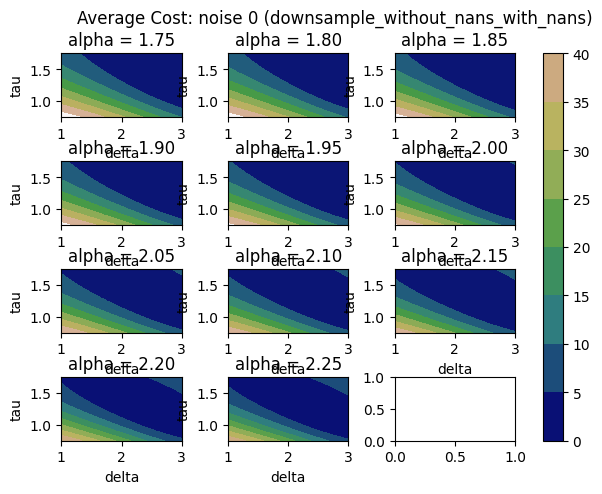

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              45.295144          
3                                              44.751447          
5                                              44.194957          
7                                              43.625817          
9                                              43.044205          
...                                                  ...          
18933                                           7.418120          
18935                                           8.065524          
18937                                           8.721347          
18939                                           9.383577          
18941                                          10.050330          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.75, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0   2.75  1.25    2.0

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.75, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.281531e-03   2.70  1.20   2.15
1      0         0  1.941015e-28   2.75  1.25   2.00
2      0         0  5.406096e-03   2.80  1.30   1.85

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 1.0059990149680267; at
       delta   tau  alpha
16400   2.75  1.25    2.0


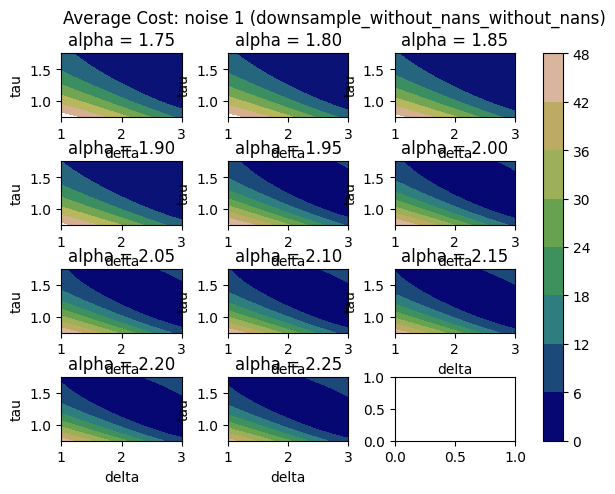

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 3.9936369010874984; at
       delta   tau  alpha
16400   2.75  1.25    2.0


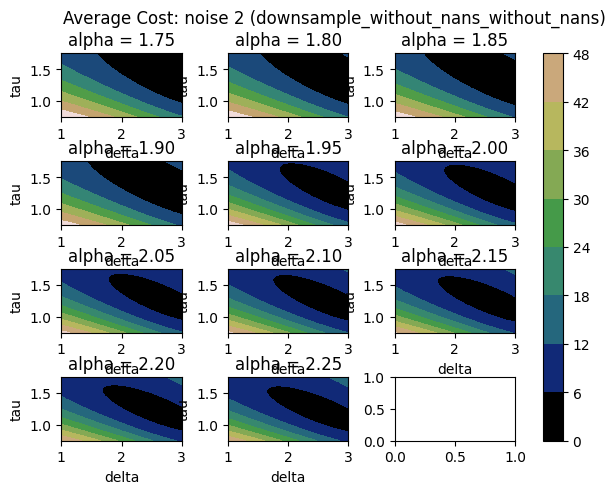

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 8.914728609077507; at
       delta   tau  alpha
16400   2.75  1.25    2.0


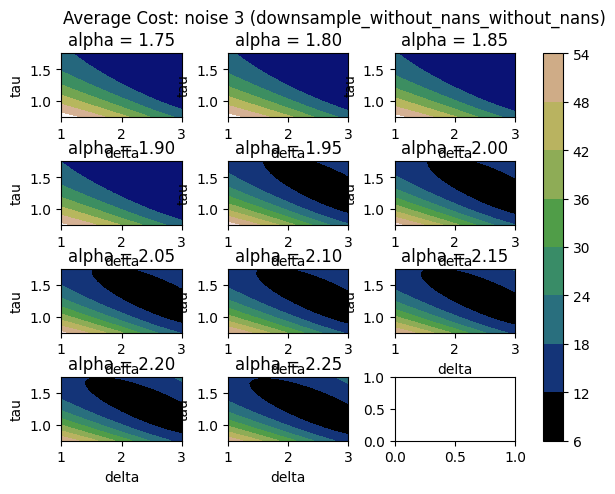

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 15.946908834864443; at
       delta   tau  alpha
16400   2.75  1.25    2.0


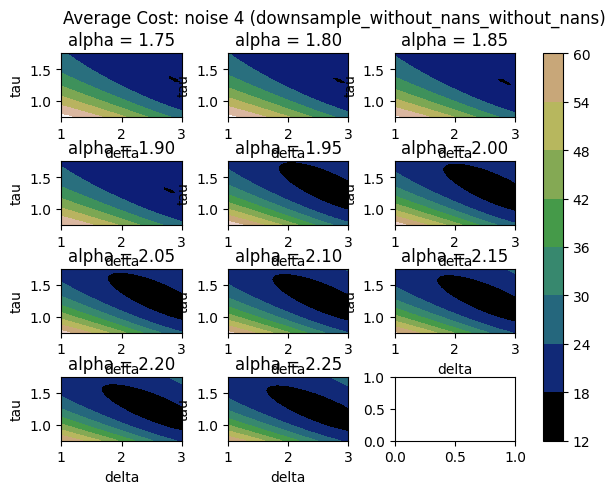

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 24.921344387287768; at
       delta   tau  alpha
16400   2.75  1.25    2.0


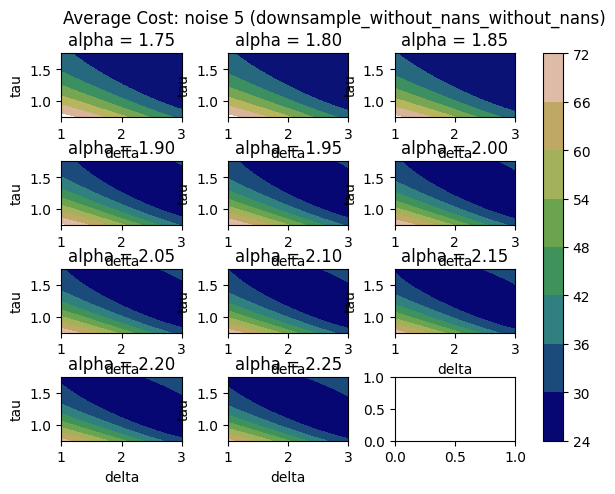

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 35.66314340425608; at
       delta   tau  alpha
16400   2.75  1.25    2.0


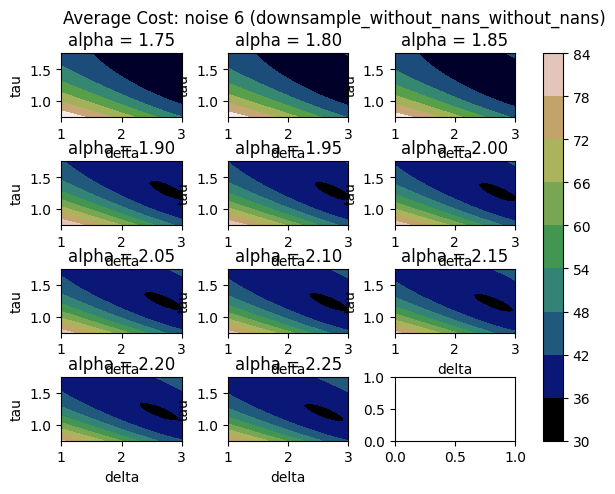

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 48.60683094503169; at
       delta   tau  alpha
16400   2.75  1.25    2.0


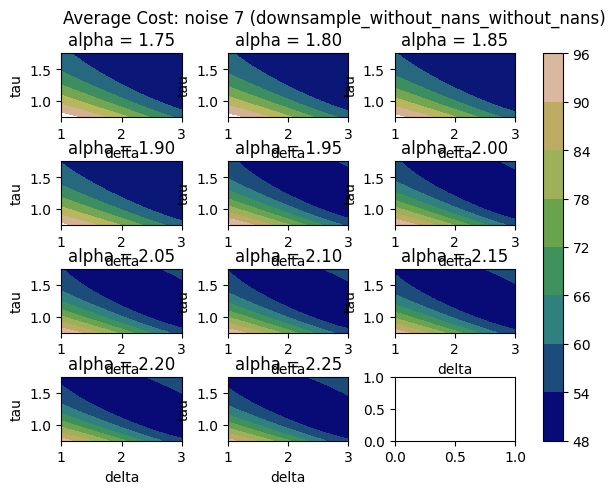

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 64.08409711493653; at
       delta   tau  alpha
15940    2.7  1.25   2.05


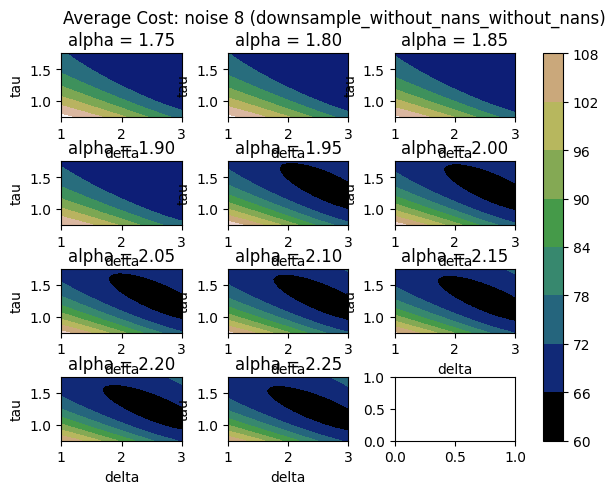

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 81.16431830924991; at
       delta   tau  alpha
15940    2.7  1.25   2.05


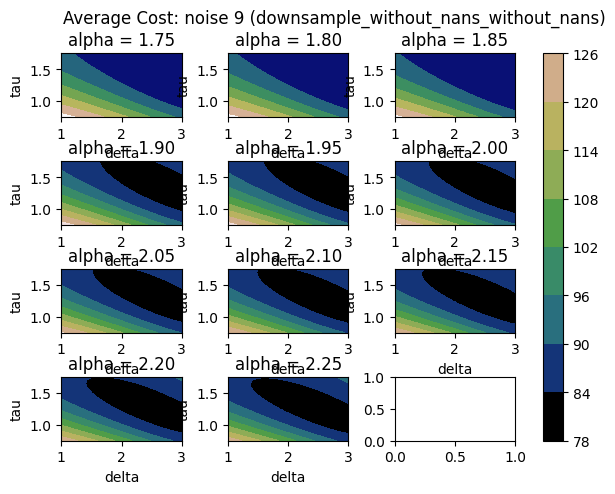

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 100.15171127118728; at
       delta  tau  alpha
16878    2.8  1.3   1.85


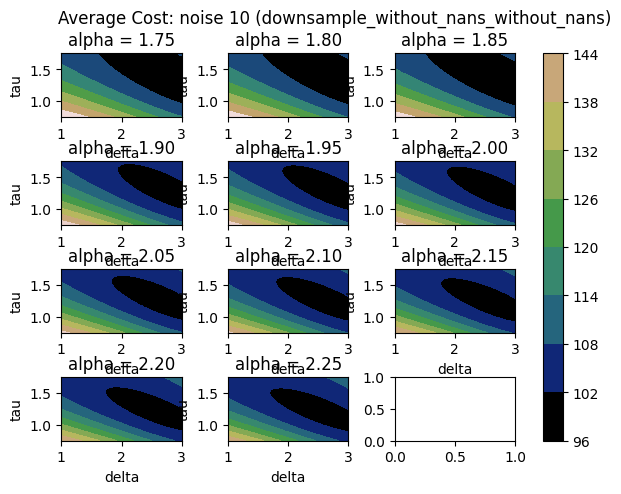

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

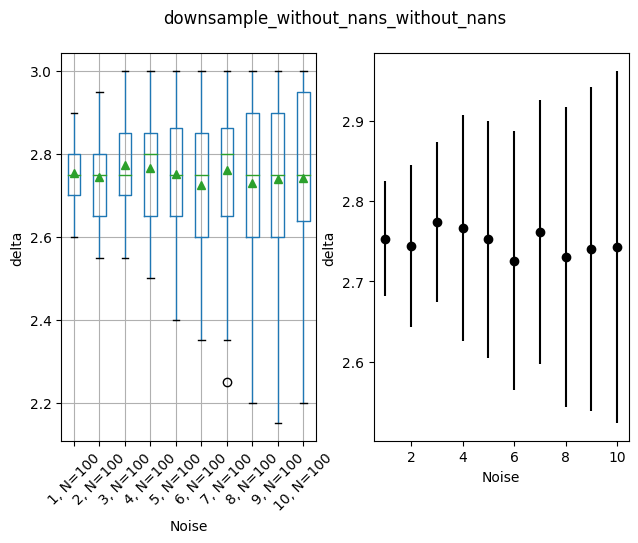

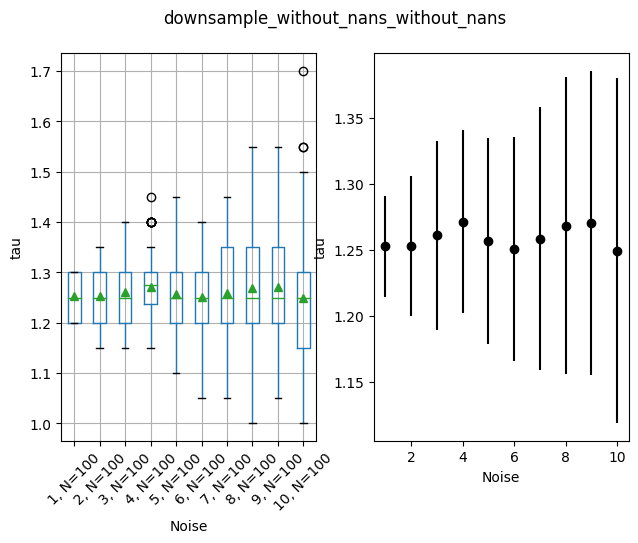

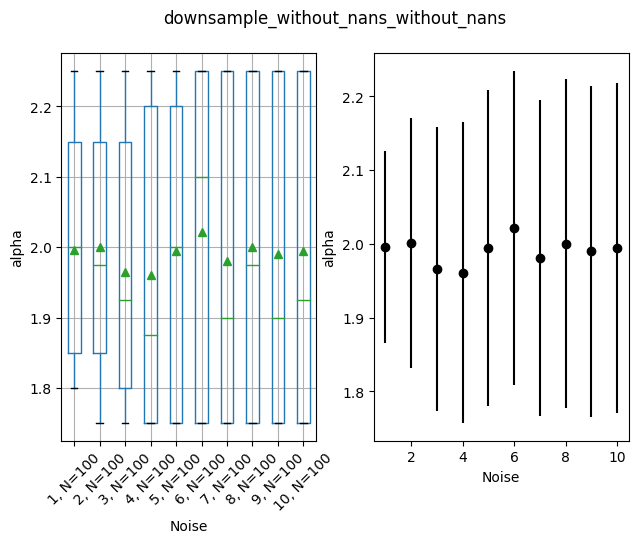

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 1.0078495167348223; at
       delta   tau  alpha
16401   2.75  1.25    2.0


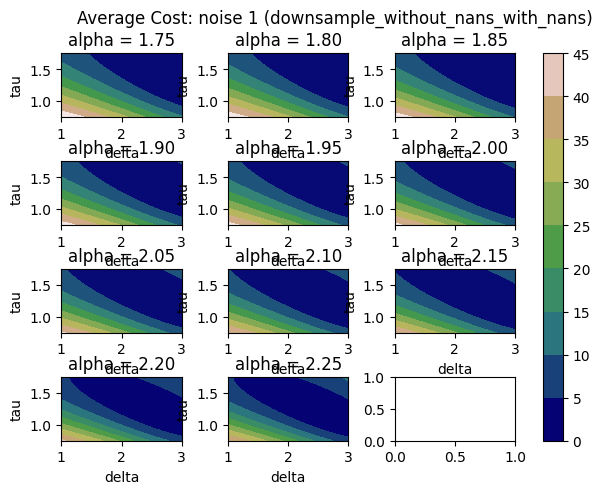

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.000423873874332; at
       delta   tau  alpha
16401   2.75  1.25    2.0


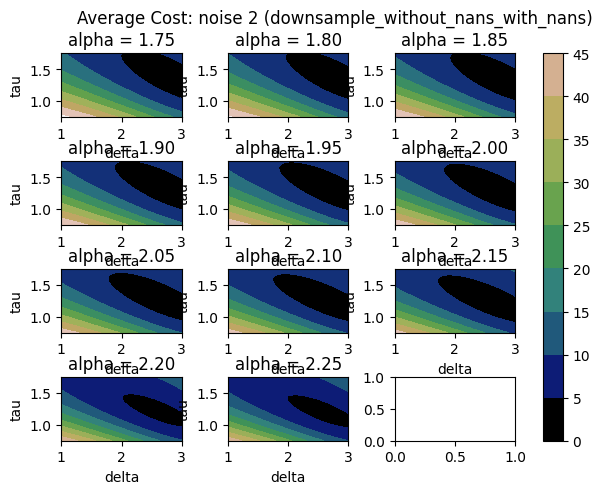

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 8.86484871174928; at
       delta   tau  alpha
16401   2.75  1.25    2.0


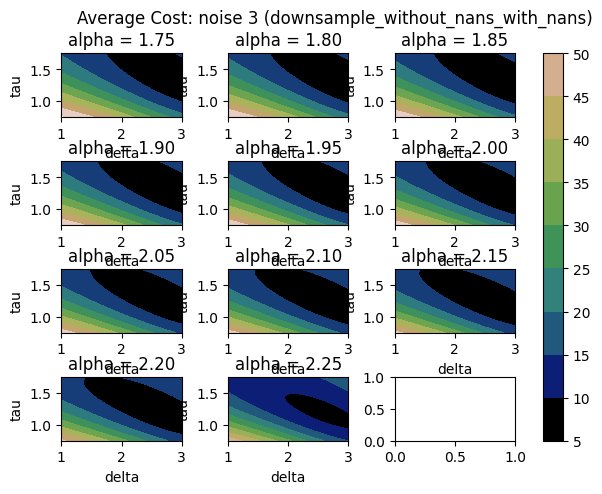

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 15.918515902662005; at
       delta   tau  alpha
16401   2.75  1.25    2.0


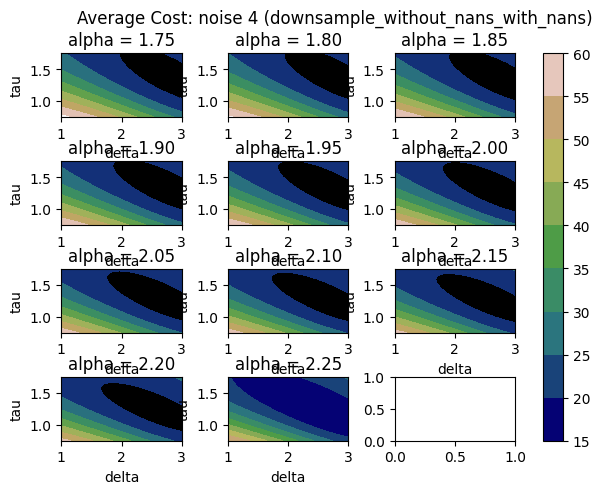

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 24.965626768411763; at
       delta   tau  alpha
16401   2.75  1.25    2.0


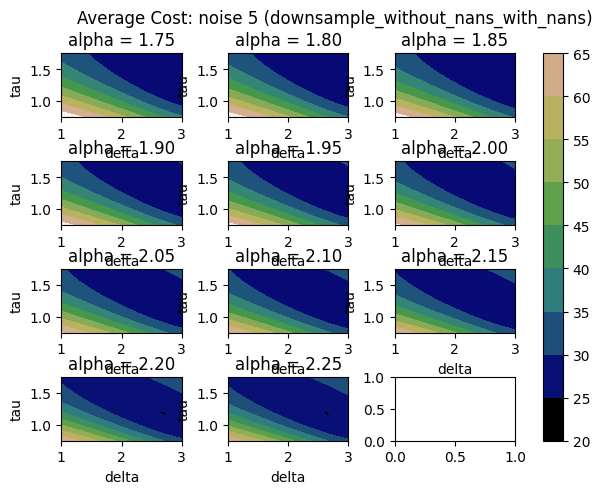

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 35.514956493549185; at
       delta  tau  alpha
15463   2.65  1.2    2.2


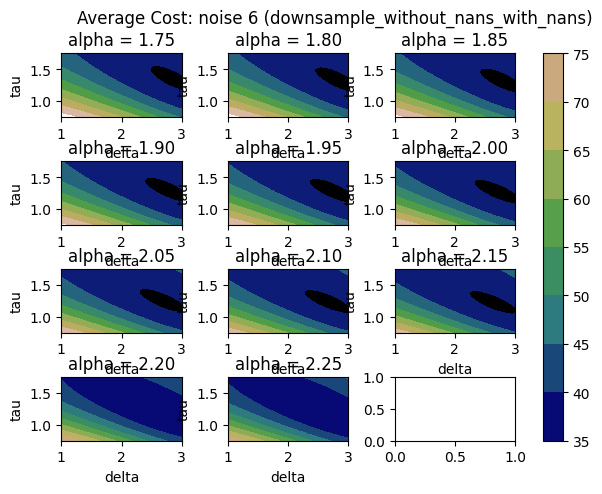

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.661598144022754; at
       delta   tau  alpha
16401   2.75  1.25    2.0


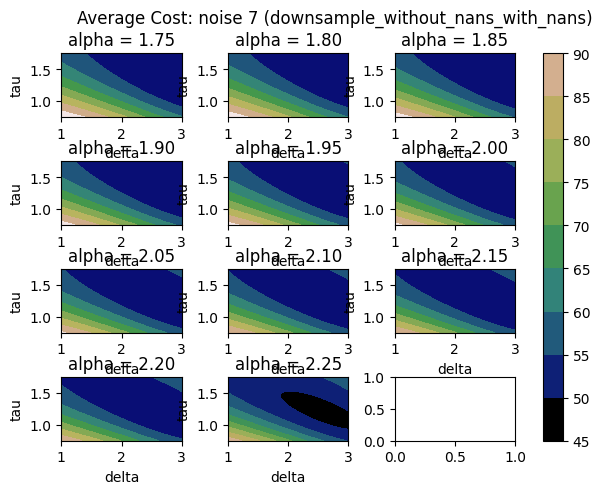

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 64.04512228130869; at
       delta   tau  alpha
15941    2.7  1.25   2.05


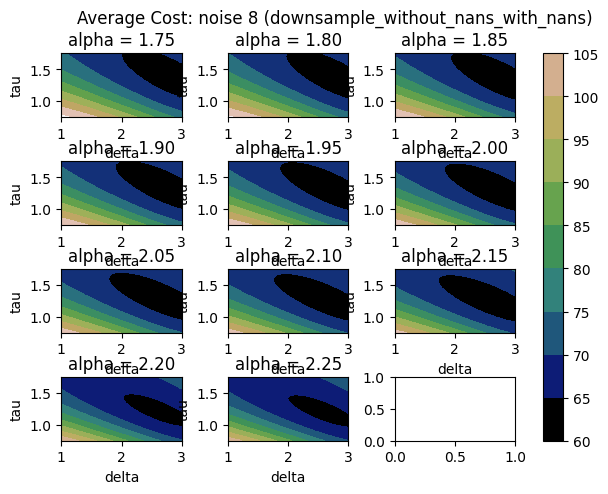

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 81.27961448223064; at
       delta   tau  alpha
15941    2.7  1.25   2.05


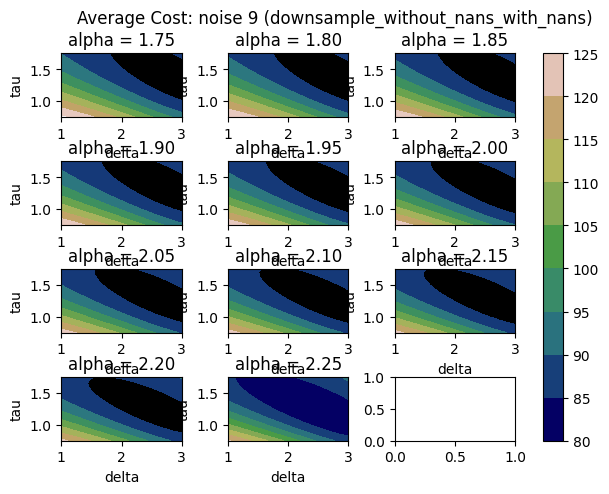

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 99.84136662368164; at
       delta  tau  alpha
15461   2.65  1.2   2.15


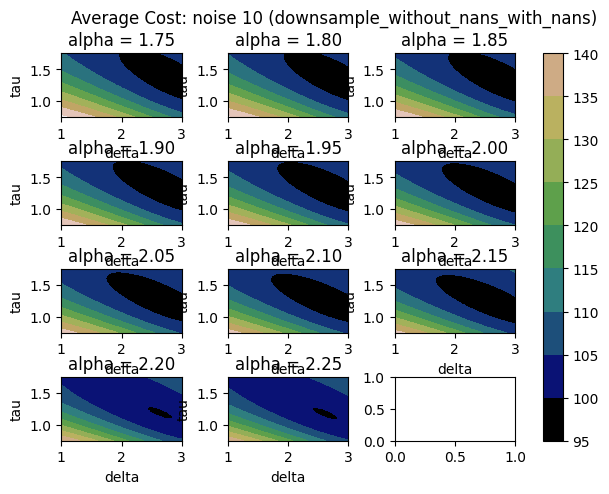

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


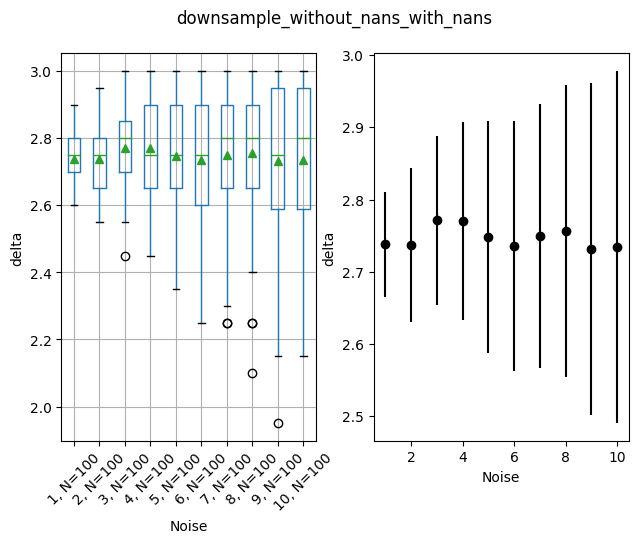

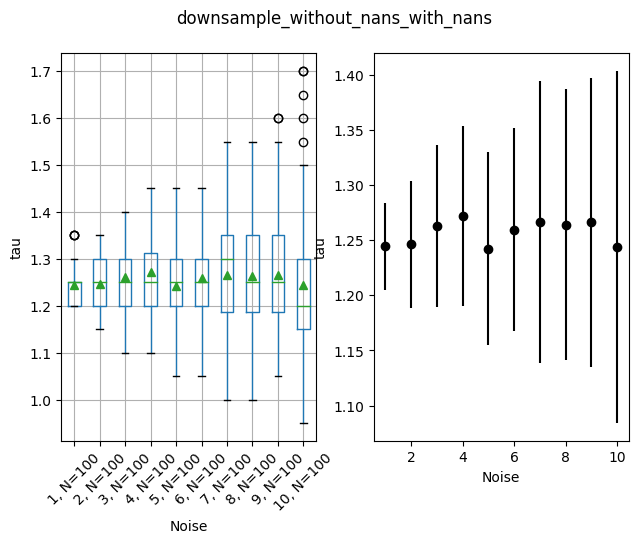

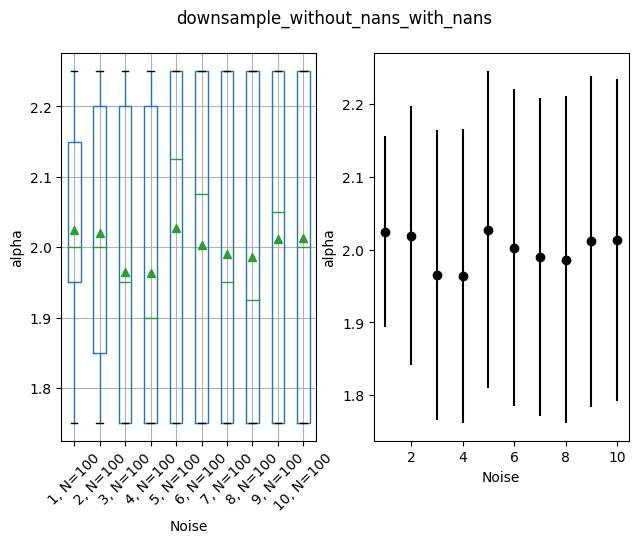

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        16    0.976520  2.5500000000000016  1.2000000000000004   
1         1        12    0.921212  2.6000000000000014  1.2000000000000004   
2         1        42    1.040780  2.6000000000000014  1.2000000000000004   
3         1        45    1.023738  2.6000000000000014  1.2000000000000004   
4         1        58    0.978148  2.6000000000000014  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2676     10        88  102.711083  3.0000000000000018  1.2500000000000004   
2677     10        24  105.060690  3.0000000000000018  1.3000000000000005   
2678     10        87   94.962639  3.0000000000000018  1.3000000000000005   
2679     10         5  108.591042  3.0000000000000018  1.3000000000000005   
2680     10         5  108.591191  3.0000000000000018  1.3500000000000005   

                   alpha  
0     2.2500000000000004  
1                    2.2  
2                    2.2  
3                    2.2  
4                    2.2  
...                  ...  
2676  1.9500000000000002  
2677                1.75  
2678                 1.8  
2679                1.85  
2680                1.75  

[2681 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.32  0.510100  2.0  3.0  3.0  4.0  4.0
2                      100.0  3.41  0.604612  2.0  3.0  3.0  4.0  4.0
3                      100.0  3.02  0.909878  1.0  3.0  3.0  4.0  4.0
4                      100.0  2.81  1.060732  1.0  2.0  3.0  4.0  4.0
5                      100.0  2.57  1.121462  1.0  1.0  3.0  3.0  4.0
6                      100.0  2.47  1.039182  1.0  2.0  3.0  3.0  4.0
7                      100.0  2.38  1.126181  1.0  1.0  2.0  3.0  4.0
8                      100.0  2.36  1.193586  1.0  1.0  2.0  3.0  4.0
9                      100.0  2.19  1.098162  1.0  1.0  2.0  3.0  5.0
10                     100.0  2.28  1.119885  1.0  1.0  2.0  3.0  4.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration        cost               delta                 tau  \
972       3        18    8.482210  3.0000000000000018  1.2500000000000004   
973       3        68    8.214337  3.0000000000000018  1.2500000000000004   
974       3        74    8.949004  3.0000000000000018  1.2500000000000004   
1244      4        33   14.667950  3.0000000000000018  1.2000000000000004   
1245      4        59   14.488768  3.0000000000000018  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2676     10        88  102.711083  3.0000000000000018  1.2500000000000004   
2677     10        24  105.060690  3.0000000000000018  1.3000000000000005   
2678     10        87   94.962639  3.0000000000000018  1.3000000000000005   
2679     10         5  108.591042  3.0000000000000018  1.3000000000000005   
2680     10         5  108.591191  3.0000000000000018  1.3500000000000005   

                   alpha  
972                  1.8  
973                  1.8  
974                  1.8  
1244  1.9000000000000001  
1245                 2.0  
...                  ...  
2676  1.9500000000000002  
2677                1.75  
2678                 1.8  
2679                1.85  
2680                1.75  

[139 rows x 6 columns]

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
253       1        12    0.928601  2.8000000000000016  1.3500000000000005   
254       1        16    0.983835  2.8000000000000016  1.3500000000000005   
255       1        42    1.048939  2.8000000000000016  1.3500000000000005   
297       1         0    0.973452  2.8500000000000014  1.3500000000000005   
298       1         3    1.093964  2.8500000000000014  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2667     10         0   91.704129  3.0000000000000018  1.2000000000000004   
2668     10         9  101.706290  3.0000000000000018  1.2000000000000004   
2672     10        62   92.431251  3.0000000000000018  1.2500000000000004   
2677     10        24  105.060690  3.0000000000000018  1.3000000000000005   
2680     10         5  108.591191  3.0000000000000018  1.3500000000000005   

     alpha  
253   1.75  
254   1.75  
255   1.75  
297   1.75  
298   1.75  
...    ...  
2667  1.75  
2668  1.75  
2672  1.75  
2677  1.75  
2680  1.75  

[386 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        29      3  2.8500000000000014   25    29      1  1.3500000000000005   
10       41     11  2.9000000000000017    7    41     11  1.3000000000000005   
2        37      4  2.8500000000000014   15    37      2  1.3500000000000005   
3        32      5  2.8500000000000014   16    32      3  1.3500000000000005   
4        46      7  2.8500000000000014   12    46      5  1.3000000000000005   
5        41      8  2.9000000000000017   11    41      6  1.3000000000000005   
6        39      8  2.8500000000000014    8    39      6  1.3000000000000005   
7        42      9  2.8500000000000014   11    42      7  1.3500000000000005   
8        40     11  3.0000000000000018    7    40      7  1.3500000000000005   
9        39      9  3.0000000000000018    8    39      8  1.3000000000000005   

            
      freq  
noise       
1       29  
10      10  
2       27  
3       18  
4       18  
5       17  
6       13  
7       15  
8       11  
9        9

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        16    0.976520  2.5500000000000016  1.2000000000000004   
6         1         0    0.965999  2.6000000000000014  1.2000000000000004   
7         1        37    1.000389  2.6000000000000014  1.2000000000000004   
8         1        54    0.940137  2.6000000000000014  1.2000000000000004   
9         1        55    1.018043  2.6000000000000014  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2603     10        96  100.777430  2.8500000000000014  1.2000000000000004   
2612     10        75  106.922081  2.9000000000000017  1.0000000000000002   
2634     10         1   89.282337   2.950000000000002  1.1000000000000003   
2650     10        67   99.161833  3.0000000000000018  1.0000000000000002   
2660     10        86  103.853878  3.0000000000000018  1.1000000000000003   

                   alpha  
0     2.2500000000000004  
6     2.2500000000000004  
7     2.2500000000000004  
8     2.2500000000000004  
9     2.2500000000000004  
...                  ...  
2603  2.2500000000000004  
2612  2.2500000000000004  
2634  2.2500000000000004  
2650  2.2500000000000004  
2660  2.2500000000000004  

[375 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        12      3  2.6000000000000014    8    12      2  1.2000000000000004   
10       42     17  2.6500000000000012    4    42      9  1.2000000000000004   
2        34      5  2.6500000000000012   11    34      2  1.2000000000000004   
3        39      6  2.6000000000000014   12    39      3  1.2000000000000004   
4        32      8  2.6500000000000012    9    32      4  1.2000000000000004   
5        40      9  2.6000000000000014   10    40      4  1.1500000000000004   
6        41     11  2.6000000000000014   12    41      6  1.1500000000000004   
7        40     15  2.6000000000000014    6    40      6  1.2000000000000004   
8        50     14  2.7000000000000015    7    50      8  1.1500000000000004   
9        45     15  2.6000000000000014    9    45      8  1.2500000000000004   

            
      freq  
noise       
1        9  
10       8  
2       19  
3       19  
4       13  
5       17  
6       14  
7       11  
8       18  
9       11

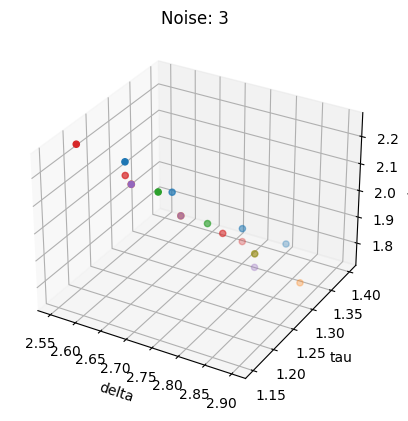

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

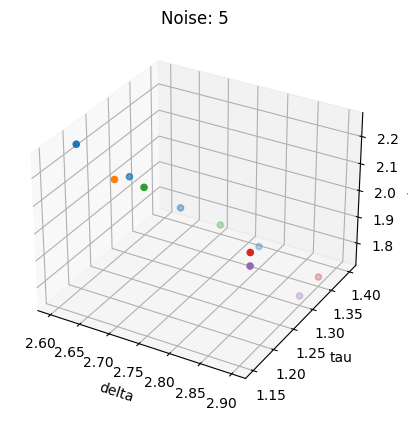

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

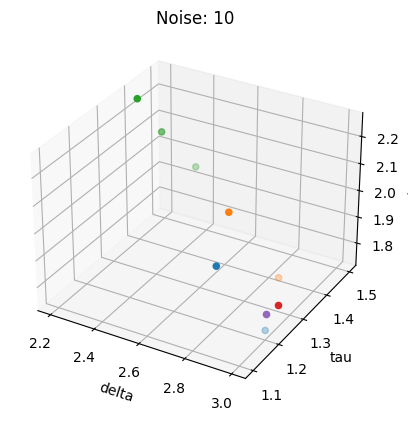

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        16    0.942791  2.5500000000000016  1.2000000000000004   
1         1        42    1.084710  2.5500000000000016  1.2000000000000004   
2         1        12    0.926336  2.6000000000000014  1.2000000000000004   
3         1        61    1.006532  2.6000000000000014  1.2000000000000004   
4         1        70    1.039086  2.6000000000000014  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2536     10        86  101.697089  3.0000000000000018  1.3500000000000005   
2537     10        94  102.826681  3.0000000000000018  1.3500000000000005   
2538     10        86  101.714481  3.0000000000000018  1.4000000000000006   
2539     10        66  105.336745  3.0000000000000018  1.4500000000000006   
2540     10        66  105.349919  3.0000000000000018  1.5000000000000007   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2                    2.2  
3                    2.2  
4                    2.2  
...                  ...  
2536                1.85  
2537                1.85  
2538                1.75  
2539                1.85  
2540                1.75  

[2541 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.29  0.537390  2.0  3.0  3.0  4.0  4.0
2                      100.0  3.30  0.758787  1.0  3.0  3.0  4.0  4.0
3                      100.0  2.93  1.075484  1.0  2.0  3.0  4.0  4.0
4                      100.0  2.62  1.061541  1.0  2.0  3.0  3.0  4.0
5                      100.0  2.35  1.048086  1.0  1.0  2.0  3.0  5.0
6                      100.0  2.22  1.097104  1.0  1.0  2.0  3.0  5.0
7                      100.0  2.35  1.122542  1.0  1.0  2.0  3.0  4.0
8                      100.0  2.16  1.195277  1.0  1.0  2.0  3.0  5.0
9                      100.0  2.03  1.048857  1.0  1.0  2.0  3.0  5.0
10                     100.0  2.16  1.079843  1.0  1.0  2.0  3.0  5.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration        cost               delta                 tau  \
658       2        83    4.067191  3.0000000000000018  1.2500000000000004   
950       3        68    7.935610  3.0000000000000018  1.2000000000000004   
951       3        53    8.261470  3.0000000000000018  1.2500000000000004   
1200      4        33   15.046455  3.0000000000000018  1.2000000000000004   
1201      4        89   15.939570  3.0000000000000018  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2536     10        86  101.697089  3.0000000000000018  1.3500000000000005   
2537     10        94  102.826681  3.0000000000000018  1.3500000000000005   
2538     10        86  101.714481  3.0000000000000018  1.4000000000000006   
2539     10        66  105.336745  3.0000000000000018  1.4500000000000006   
2540     10        66  105.349919  3.0000000000000018  1.5000000000000007   

                   alpha  
658                  1.8  
950   1.9000000000000001  
951                  1.8  
1200  1.9000000000000001  
1201  1.9000000000000001  
...                  ...  
2536                1.85  
2537                1.85  
2538                1.75  
2539                1.85  
2540                1.75  

[191 rows x 6 columns]

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
295       1         0    0.994306  2.8500000000000014  1.3500000000000005   
296       1         3    1.063876  2.8500000000000014  1.3500000000000005   
297       1         8    1.029318  2.8500000000000014  1.3500000000000005   
298       1        23    1.078745  2.8500000000000014  1.3500000000000005   
299       1        29    1.016195  2.8500000000000014  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2493     10        61  102.731661   2.950000000000002  1.3500000000000005   
2522     10         3  103.009798  3.0000000000000018  1.2000000000000004   
2530     10        24  107.516186  3.0000000000000018  1.3000000000000005   
2538     10        86  101.714481  3.0000000000000018  1.4000000000000006   
2540     10        66  105.349919  3.0000000000000018  1.5000000000000007   

     alpha  
295   1.75  
296   1.75  
297   1.75  
298   1.75  
299   1.75  
...    ...  
2493  1.75  
2522  1.75  
2530  1.75  
2538  1.75  
2540  1.75  

[397 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        26      2  2.8500000000000014   24    26      1  1.3500000000000005   
10       40     13  2.9000000000000017    8    40     12  1.4500000000000006   
2        33      4  2.9000000000000017   14    33      2  1.3500000000000005   
3        46      6  2.8500000000000014   12    46      4  1.3000000000000005   
4        45      8  2.8500000000000014    9    45      5  1.3000000000000005   
5        36      9   2.950000000000002    9    36      5  1.3000000000000005   
6        40      9  2.9000000000000017   11    40      6  1.3500000000000005   
7        46     11  2.8000000000000016    9    46      8  1.4000000000000006   
8        47     12  3.0000000000000018    9    47      8  1.3500000000000005   
9        38     12  3.0000000000000018    7    38     10  1.3000000000000005   

            
      freq  
noise       
1       26  
10       8  
2       20  
3       21  
4       17  
5       13  
6       13  
7       15  
8       13  
9        8

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        16    0.942791  2.5500000000000016  1.2000000000000004   
1         1        42    1.084710  2.5500000000000016  1.2000000000000004   
5         1        25    1.058684  2.6000000000000014  1.2000000000000004   
6         1        37    0.986904  2.6000000000000014  1.2000000000000004   
7         1        54    0.911995  2.6000000000000014  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2504     10        51  101.378624  3.0000000000000018  1.0500000000000003   
2505     10        65  105.549935  3.0000000000000018  1.0500000000000003   
2513     10        30  100.269987  3.0000000000000018  1.1000000000000003   
2514     10        67   98.953255  3.0000000000000018  1.1000000000000003   
2521     10        84  109.537202  3.0000000000000018  1.1500000000000004   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
5     2.2500000000000004  
6     2.2500000000000004  
7     2.2500000000000004  
...                  ...  
2504  2.2500000000000004  
2505  2.2500000000000004  
2513  2.2500000000000004  
2514  2.2500000000000004  
2521  2.2500000000000004  

[405 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        16      3  2.6000000000000014   10    16      2  1.2000000000000004   
10       46     18  3.0000000000000018    9    46     10  1.1500000000000004   
2        44      6  2.6500000000000012   14    44      3  1.2000000000000004   
3        40      8  2.7000000000000015   14    40      4  1.1500000000000004   
4        36      8  2.7000000000000015   11    36      4  1.1500000000000004   
5        44     12  2.7000000000000015    9    44      6  1.1500000000000004   
6        47     13  2.5500000000000016   10    47      6  1.2000000000000004   
7        40     16  3.0000000000000018    5    40      9  1.2000000000000004   
8        44     16  2.7000000000000015    5    44      9  1.1500000000000004   
9        48     18  2.6000000000000014    6    48      8  1.2000000000000004   

            
      freq  
noise       
1       12  
10       9  
2       22  
3       22  
4       24  
5       15  
6       14  
7        9  
8       13  
9       14

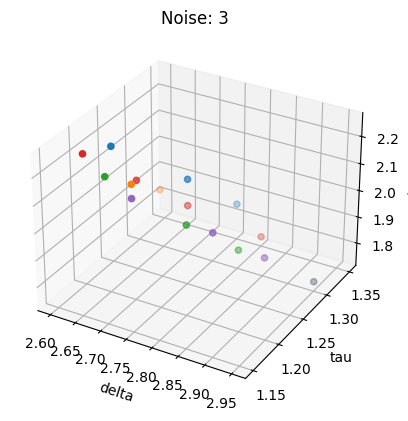

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

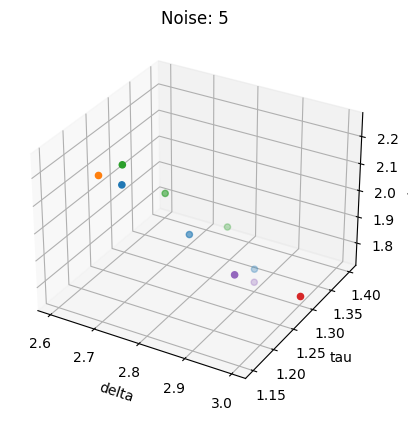

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

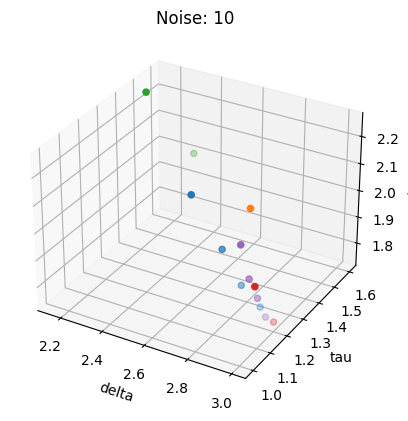

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()